In [1]:
using Revise

In [14]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
import OpticalBlochEquations: extend_operator
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_v2.jl")
# working_dir = "G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"
working_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\repump"
;

In [9]:
function SE_collapse_repump!(integrator)
    # go back to bright state
    if integrator.p.is_dark == true
        integrator.p.is_dark = false
        n_states = length(integrator.p.states)
        n_excited = integrator.p.n_excited
        i = Int(floor(rand()*n_excited)) + 1
        for i in 1:n_states
            integrator.u[i] = 0.0
        end
        integrator.u[n_states - n_excited + i] = 1.0
#         println()
#         println("Molecule out of jail.")
    else
        # scatter
       rn = rand()
        if rn < integrator.p.FC_mainline # decay back to a cycling state
            SE_collapse_pol_always!(integrator)
        else # decay into a dark state and wait to be repumped
            SE_collapse_pol_always!(integrator) # give a momentum kick
            integrator.p.is_dark = true
            integrator.p.dark_time = rand(integrator.p.dark_time_dist)
            integrator.p.dark_time_t0 = integrator.t
#             n_excited = integrator.p.n_excited
#             n_states = length(integrator.p.states)

#             @printf("Molecule put in jail at time %.1e", integrator.t / Γ)
#             println()
#             @printf("dark_time = %.1e", integrator.p.dark_time/Γ)
        end
    end
end

SE_collapse_repump! (generic function with 1 method)

In [10]:
package = get_CaOH_package();
n_states = length(package.states)
n_excited = package.n_excited;
package.states[5].E - package.states[1].E

5.1240297796562195e7

test18/19: no repump state/inf repump rate, survival 34/40, size=(0.09, 0.06, 0.03)mm, Tx=95uK, 1.56MHz
test20: 1MHz repump, survival 37/40, size=(0.08, 0.08, 0.045)mm, Tx=95uK, 1.49 MHz
test21: 500kHz repump, survival 26/40, (0.08, 0.075, 0.036)mm, Tx=94uK, 1.58MHz
test22: 200kHz repump, suvival 31/40, (0.08, 0.09, 0.04)mm, Tx=105uK, 1.3MHz
test24: 100kHz repump, survival 26/40, (0.1, 0.1, 0.04)mm, Ty=100uK, 910kHz
test25, 26: 50kHz repump, survival 28/40, (0.1, 0.095, 0.06)mm, Ty=85uK, 650kHz
test27: 20kHz repump, survival 26/40, (0.16, 0.13, 0.065)mm, Ty=50uK, 340kHz
# survival scattering rate

In [140]:
i_test = 24
params = load_test_params(working_dir, i_test)
results = load_results(working_dir, i_test);
1/params.dark_lifetime
@printf("goodness = %.2f", goodness(params.t_end, results))

Survival: 26 / 40
goodness = 0.15

In [87]:
Δ1 = 6e6 * 2π; Δ3 = Δ1 + 51.24e6*2π - 53.55e6 * 2π 
Δ1/Γ

0.9375000000000001

In [11]:
function get_Δ_from_exp(voltage, aom_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 57 - 7.4*(5.5-voltage)
    Δ2 = Δ1 + 51.24 - aom_freq
    return Δ1, Δ2
end


Δ1, Δ2 = get_Δ_from_exp(-1.4, 53.55)
println(Δ2* 1e6 * 2π/Γ)

0.5671875000000004


In [12]:
 (57 - 7.4*(5.5-2))

31.099999999999998

In [13]:
temp = @with_unit 0.08 "mK"
diameter = @with_unit 0.1 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
    


# s1=3.0; s3=5.06; s4=4.45; Δ1=Δ3=1.83Γ; Δ4=-7.1Γ #current
# s1=1.5; s3=3; s4=5.5; Δ1=Δ3=1Γ; Δ4=-8Γ #try

# s1=1*3; s3=1.5*3; s4=2.0*3; Δ1=Δ3=2.17Γ; Δ4=-6.4Γ # opt


# s1 = 0.71; s3 = 1.74; Δ1 = 2.60Γ; Δ3 = 2.66Γ # - B field, sig-sig+ opt, test105,109 goodness=0.17
# s1 = 1.34; s3 = 2.58; Δ1 = 1.27Γ; Δ3 = 0.83Γ # + B field, sig-sig+ opt, test106, goodness = 0.05
# s1 = 0.71; s3 = 1.70; Δ1 = 2.26Γ; Δ3 = 1.87Γ # - B field, sig+sig+ opt, test103, goodness=0.06

# s1 = 3/3; s3 = 4.5/3; Δ1 = 2.19Γ; Δ3 = 2.19Γ # exp, test107,108,110 goodness = 0.07




voltage = -1.4
aom_freq = 53.55

s1 = 2.18/2; s3 = 1.82/2; 

Δ1 = get_Δ_from_exp(voltage, aom_freq)[1] * 1e6 * 2π; 
Δ3 = get_Δ_from_exp(voltage, aom_freq)[2] * 1e6 * 2π; 

s4 = 0.0
Δ4 = 0.0
s2 = 0.0
Δ2 = 0.0

s3 = 0.0
s1 = 5.0
Δ1 = (57 - 7.4*(5.5-2)) * 1e6 * 2π



params = MutableNamedTuple(t_end = 1e-3, n_values = 1,
                            pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁺, 
                            s1=s1, s2=s2, s3=s3, s4=s4,
                            Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                            B_gradient = 50.0*0, 
                            Bz_offset = 0.5, By_offset = 0.0, Bx_offset=0.0,

                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            s_ramp_time = 10e-3,
                            s_ramp_to_factor = 1.0,
                            ramp_time = 10e-3,
                            photon_budget=Inf, dark_lifetime=1/(1e6), FC_mainline=0.95,

                            pol_imbalance=0.02, 
                            s_imbalance = (0.1, 0.1, -0.0), retro_loss=0.02, 
                            
                            off_center=[2, 2, -2, 2, -2, -2].*1e-3, 
                            pointing_error =[0.05, 0.0, 0.05,0,0,0] )

# test_i = log_test_info(working_dir,1,params)
@time results = simulate_particles(package, params, variable_budget=true)
save_results(working_dir, test_i, results)
# @printf("goodness of test %i = %.2f", test_i, goodness(params.t_end, results))

LoadError: TaskFailedException

[91m    nested task error: [39mUndefVarError: `update_H_and_∇H` not defined
    Stacktrace:
     [1] [0m[1mschrodinger_stochastic_repump[22m[0m[1m([22m[90mparticle[39m::[0mParticle, [90mstates[39m::[0mVector[90m{State{HundsCaseB_Rot}}[39m, [90mfields[39m::[0mVector[90m{Field{Float64, var"#48#53"{SVector{3, ComplexF64}}, var"#51#59"{Float64, Float64, Float64, Tuple{Int64, Int64}, Tuple{Float64, Float64}}}}[39m, [90md[39m::[0mArray[90m{ComplexF64, 3}[39m, [90mψ₀[39m::[0mVector[90m{ComplexF64}[39m, [90mmass[39m::[0mFloat64, [90mn_excited[39m::[0mInt64; [90mextra_p[39m::[0mMutableNamedTuple[90m{(:Zeeman_Hx, :Zeeman_Hy, :Zeeman_Hz, :gradient_z, :gradient_x, :gradient_y, :n_excited, :ramp_time, :photon_budget, :Bz_offset, :Bx_offset, :By_offset), Tuple{Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Int64}, Vararg{Base.RefValue{Float64}, 5}}}[39m, [90mλ[39m::[0mFloat64, [90mΓ[39m::[0mFloat64, [90mupdate_H[39m::[0mFunction, [90mdark_lifetime[39m::[0mFloat64, [90mFC_mainline[39m::[0mFloat64[0m[1m)[22m
    [90m   @[39m [36mOpticalBlochEquations[39m [90mH:\My Drive\github\OpticalBlochEquations\src\[39m[90m[4mstochastic_schrodinger.jl:1082[24m[39m
     [2] [0m[1mschrodinger_stochastic_repump[22m
    [90m   @[39m [90mH:\My Drive\github\OpticalBlochEquations\src\[39m[90m[4mstochastic_schrodinger.jl:994[24m[39m[90m [inlined][39m
     [3] [0m[1mmake_problem_with_param[22m[0m[1m([22m[90mmolecule_package[39m::[0mMutableNamedTuple[90m{(:states, :n_excited, :d, :Zeeman_x_mat, :Zeeman_y_mat, :Zeeman_z_mat), Tuple{Base.RefValue{Vector{State{HundsCaseB_Rot}}}, Base.RefValue{Int64}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}}}[39m, [90mparam[39m::[0mMutableNamedTuple[90m{(:t_end, :n_values, :pol1_x, :pol2_x, :pol3_x, :pol4_x, :s1, :s2, :s3, :s4, :Δ1, :Δ2, :Δ3, :Δ4, :B_gradient, :Bz_offset, :By_offset, :Bx_offset, :temp, :diameter, :displacement, :kick, :s_ramp_time, :s_ramp_to_factor, :ramp_time, :photon_budget, :dark_lifetime, :FC_mainline, :pol_imbalance, :s_imbalance, :retro_loss, :off_center, :pointing_error), Tuple{Base.RefValue{Float64}, Base.RefValue{Int64}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Vector{Float64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Tuple{Float64, Float64, Float64}}, Base.RefValue{Float64}, Base.RefValue{Vector{Float64}}, Base.RefValue{Vector{Float64}}}}[39m; [90mvariable_budget[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [35mMain[39m [90mH:\My Drive\github\OpticalBlochEquations\examples\ipynb_sources\toy_models\CaOH_scan\[39m[90m[4mCaOH_scan_helper_repump.jl:454[24m[39m
     [4] [0m[1mmake_problem_with_param[22m
    [90m   @[39m [90mH:\My Drive\github\OpticalBlochEquations\examples\ipynb_sources\toy_models\CaOH_scan\[39m[90m[4mCaOH_scan_helper_repump.jl:300[24m[39m[90m [inlined][39m
     [5] [0m[1mmacro expansion[22m
    [90m   @[39m [90mH:\My Drive\github\OpticalBlochEquations\examples\ipynb_sources\toy_models\CaOH_scan\[39m[90m[4mCaOH_scan_helper_repump.jl:495[24m[39m[90m [inlined][39m
     [6] [0m[1m(::var"#151#threadsfor_fun#69"{var"#151#threadsfor_fun#61#70"{Bool, MutableNamedTuple{(:states, :n_excited, :d, :Zeeman_x_mat, :Zeeman_y_mat, :Zeeman_z_mat), Tuple{Base.RefValue{Vector{State{HundsCaseB_Rot}}}, Base.RefValue{Int64}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}}}, MutableNamedTuple{(:t_end, :n_values, :pol1_x, :pol2_x, :pol3_x, :pol4_x, :s1, :s2, :s3, :s4, :Δ1, :Δ2, :Δ3, :Δ4, :B_gradient, :Bz_offset, :By_offset, :Bx_offset, :temp, :diameter, :displacement, :kick, :s_ramp_time, :s_ramp_to_factor, :ramp_time, :photon_budget, :dark_lifetime, :FC_mainline, :pol_imbalance, :s_imbalance, :retro_loss, :off_center, :pointing_error), Tuple{Base.RefValue{Float64}, Base.RefValue{Int64}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Vector{Float64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Tuple{Float64, Float64, Float64}}, Base.RefValue{Float64}, Base.RefValue{Vector{Float64}}, Base.RefValue{Vector{Float64}}}}, ContinuousCallback{typeof(condition), typeof(SE_collapse_repump!), Nothing, typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}, Vector{Float64}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Int64, Int64, Progress, Int64, Int64, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [35mMain[39m [90m.\[39m[90m[4mthreadingconstructs.jl:206[24m[39m
     [7] [0m[1m#151#threadsfor_fun[22m
    [90m   @[39m [90m.\[39m[90m[4mthreadingconstructs.jl:173[24m[39m[90m [inlined][39m
     [8] [0m[1m(::Base.Threads.var"#1#2"{var"#151#threadsfor_fun#69"{var"#151#threadsfor_fun#61#70"{Bool, MutableNamedTuple{(:states, :n_excited, :d, :Zeeman_x_mat, :Zeeman_y_mat, :Zeeman_z_mat), Tuple{Base.RefValue{Vector{State{HundsCaseB_Rot}}}, Base.RefValue{Int64}, Base.RefValue{Array{ComplexF64, 3}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}, Base.RefValue{StructArray{ComplexF64, 2, NamedTuple{(:re, :im), Tuple{Matrix{Float64}, Matrix{Float64}}}, Int64}}}}, MutableNamedTuple{(:t_end, :n_values, :pol1_x, :pol2_x, :pol3_x, :pol4_x, :s1, :s2, :s3, :s4, :Δ1, :Δ2, :Δ3, :Δ4, :B_gradient, :Bz_offset, :By_offset, :Bx_offset, :temp, :diameter, :displacement, :kick, :s_ramp_time, :s_ramp_to_factor, :ramp_time, :photon_budget, :dark_lifetime, :FC_mainline, :pol_imbalance, :s_imbalance, :retro_loss, :off_center, :pointing_error), Tuple{Base.RefValue{Float64}, Base.RefValue{Int64}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{SVector{3, ComplexF64}}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Vector{Float64}}, Base.RefValue{Vector{Float64}}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Float64}, Base.RefValue{Tuple{Float64, Float64, Float64}}, Base.RefValue{Float64}, Base.RefValue{Vector{Float64}}, Base.RefValue{Vector{Float64}}}}, ContinuousCallback{typeof(condition), typeof(SE_collapse_repump!), Nothing, typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}, Vector{Float64}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Int64, Int64, Progress, Int64, Int64, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m.\[39m[90m[4mthreadingconstructs.jl:145[24m[39m

In [70]:
# load_test = test_i = 112
# params = load_test_params(working_dir, load_test)
# results = load_results(working_dir, load_test);
# display_test_info(working_dir, load_test)
# @printf("repumping rate = %.1e Hz", 1/params.dark_lifetime)
# println()
# @printf("goodness of test %i = %.2f", test_i, goodness(params.t_end, results))

In [15]:
# mainline_rate = 1.5e6
# 1/(1-params.FC_mainline)/((1/(1-params.FC_mainline)-1)/mainline_rate + params.dark_lifetime)/1e6

In [213]:
r = mean([results.photons_scattered[i] / (results.times[i][end]+0.1) for i in 1:length(results.times)])
@printf("Average scattering rate = %.3f MHz", r/1000)
println()
@printf("Radiative loss: %.3f", 1-exp(-r*20/14000))

Average scattering rate = 0.085 MHz
Radiative loss: 0.114

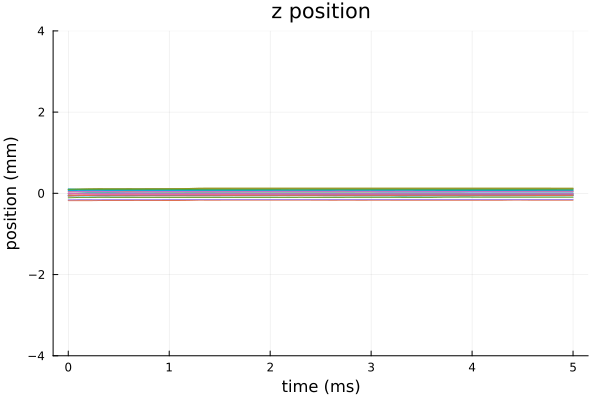

In [200]:
plot_all_trajectories(results, "z")
plot!(dpi=300,ylim=[-4, 4])
savefig(joinpath(working_dir, @sprintf("test%i//trajectory.png", test_i)))
plot!(ylim=[-4, 4], dpi=100)

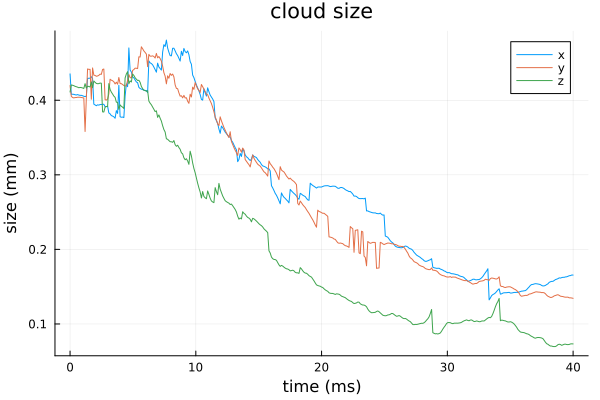

In [34]:
plot_t, σx, σy, σz = plot_size(results, "all")
# savefig(joinpath(working_dir, @sprintf("test%i//size.png", test_i)))
plot!()

In [124]:
σx[end], σy[end], σz[end]

(0.09294433391402486, 0.11045664152732683, 0.07009123112154661)

T = 38.6 μK

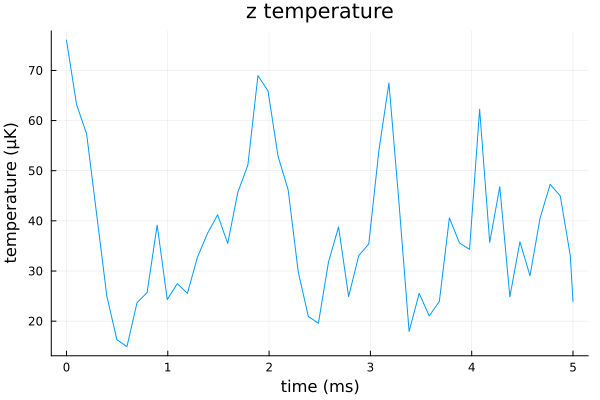

In [220]:
plot_ts, Ts= plot_temperature(results, "z")
@printf("T = %.1f μK", mean(Ts[end-10:end]))
plot!()

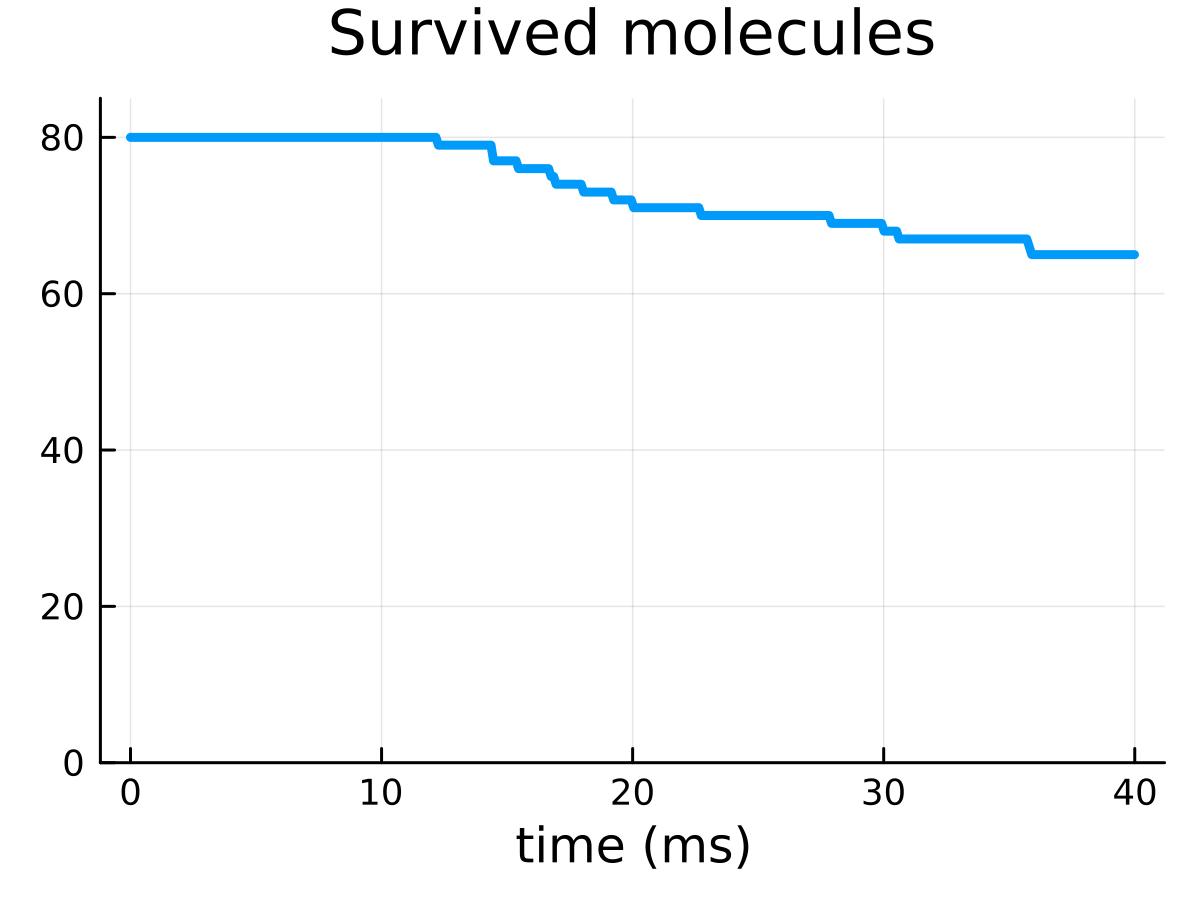

In [36]:
plot_survival(params, results; keep=false, label="")
plot!()

Average scattering rate: 0.197 MHz

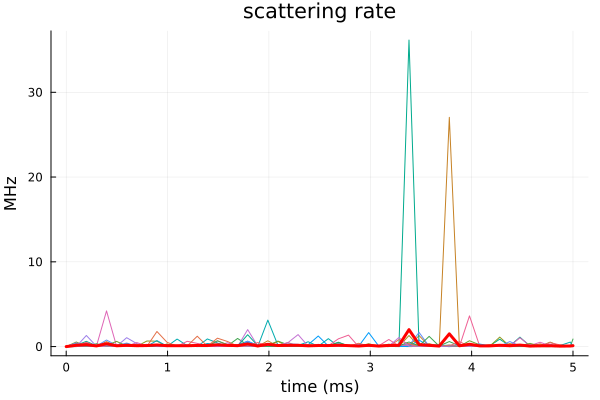

In [219]:
avg_rate = plot_scattering_rate(results)
@printf("Average scattering rate: %.3f MHz", avg_rate)
plot!()

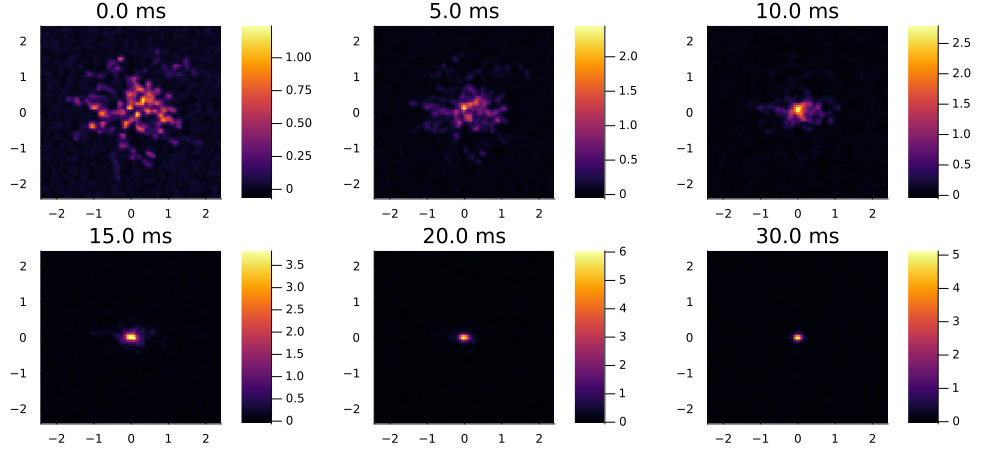

In [40]:
using ImageFiltering

ROI = 16e-3*300/2 

img_duration = 10
# ROI = 2.0
n_pixels = 100

# ts = [0.0, 2, 4,  8,  12, 20]
ts = [0.0,5,10,15,20,30]
filter = 1
cmax = 2
plots = []
for t in ts
#     x, z, grids = make_2D_image(results,-ROI,ROI,n_pixels,t=t)
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, const_scattering=false, noise=0.02, photon_budget=14000)
    imgg = imfilter(grids, Kernel.gaussian(filter))
    push!(plots, heatmap(x,z,imgg', title=@sprintf("%.1f ms", t)))
end
plot(plots[1],plots[2],plots[3],plots[4],plots[5],plots[6], size=(1000,450))
# savefig(joinpath(working_dir, @sprintf("test%i//camera_images.png", test_i)))
plot!()

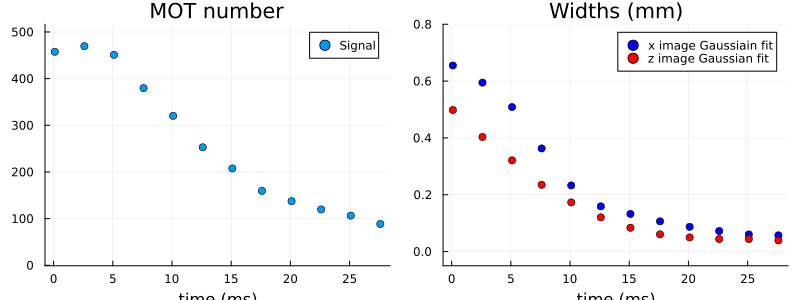

In [44]:
ts = (0.1:2.5:30)
x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=0, t_img=img_duration, photon_budget=14000)
signal = []
for t in ts
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, photon_budget=14000)
    push!(signal, sum(grids))
end

# plot_survival(params, results, keep=false, label="actual molecule number")
plot1 = scatter(ts, signal, label="Signal", xlabel="time (ms)", title="MOT number", ylim=(-1,maximum(signal)*1.1), size=(500,400));


σxs = []
x_centres = []
σzs = []
z_centres = []
    
filter = 0.1

for t in ts
#     x, z, grids = make_2D_image(results,-ROI,ROI,n_pixels,t=t)
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, photon_budget=14000)
    grids = imfilter(grids, Kernel.gaussian(filter))
        
    xs = repeat(x, 1, length(z))
    zs = repeat(z', length(x),1)
    p0 = [0.0, 0.0, 0.4, 0.4, 1.0]
    result = optimize(least_sq_cost, p0);
    p_opt = result.minimizer;
    push!(σxs, abs.(p_opt[3]))
    push!(σzs, abs.(p_opt[4]))
    push!(x_centres, p_opt[1])
    push!(z_centres, p_opt[2])
end
    
plot_ts, σx, σy, σz = plot_size(results, "all")

plot2 = scatter(ts, σxs,color=:blue, linestyle=:dash, label="x image Gaussiain fit")
scatter!(ts, σzs,color=:red, linestyle=:dash, size=(500,400), label="z image Gaussian fit")
# plot!(plot_ts,color=:blue, σx, label="actual σx")
# plot!(plot_ts,color=:red, σz, label="actual σz")
plot!(xlabel="time (ms)", title="Widths (mm)", ylim=(-0.05,0.8));
    
plot!(plot1, plot2, size=(800,300))
# savefig(joinpath(working_dir, @sprintf("test%i//camera_fits.png", test_i)))
plot!()

In [31]:
using Optim

# Define the 2D Gaussian function
function gaussian2d(x, y, p)
    xc, yc, σx, σy, A = p
    return A * exp.(-((x .- xc) .^ 2 / (2 * σx^2) + (y .- yc) .^ 2 / (2 * σy^2)))
end


function least_sq_cost(params)
    predicted = [gaussian2d(xx, zz, params) for xx in x, zz in z]
    return sum((predicted - grids).^2)
end

using Optim
;

function get_trapped_indicies(param, results)
   t_max =  param.t_end*1e3
    trapped_indicies = Int[]
    for i in 1:length(results.times)
        if results.times[i][end] ≈ t_max
           push!(trapped_indicies, i) 
        end
    end
    return trapped_indicies
end;

function make_2D_image(results, x_min, x_max, n_pixels;t=0.0,photon_budget=Inf)
    """ grids = population """
    max_t_id = 1
     plot_ts = Float64[]
    for i in 1:length(results.times)
         if length(results.times[i]) > max_t_id
             max_t_id = length(results.times[i])  
             plot_ts = results.times[i]
         end                                                                                                          
     end
   dt = plot_ts[2] - plot_ts[1]
    it = Int(t ÷ dt) + 1

    grids = zeros(n_pixels, n_pixels)
    x = LinRange(x_min, x_max, n_pixels)
    dx = x[2]-x[1]
    z = LinRange(x_min, x_max, n_pixels)
    for i in 1:length(results.times)
        if it > length(results.times[i])
            continue
        end
        x_end = results.x_trajectories[i][it]
        z_end = results.z_trajectories[i][it]
        n_photons = sum(results.A_populations[i][1:it]*dt*Γ/1000)
       if  (x_min < x_end < x_max) && (x_min < z_end < x_max)
           ix = Int((x_end - x_min) ÷ dx + 1)
            iz = Int((z_end - x_min) ÷ dx + 1)
            grids[ix, iz] += 1 * exp(-n_photons / photon_budget)
        end
    end
    return x, z, grids
end

function take_camera_image(results, x_min, x_max, n_pixels;t=0.0, t_img=0.0, const_scattering=false, noise=0.0,photon_budget=Inf)
    x, z, grids = make_2D_image(results, x_min, x_max, n_pixels;t=t, photon_budget=photon_budget)
    dt = 0.5
    if const_scattering
        grids = grids .* dt 
    else
        grids = grids .* scattering_rate_at_t(results, t+0.1) * dt 
    end
    if t_img <= 0.5
        return x, z, grids
    else
        t_curr = t + dt
        while t_curr < t + t_img
            ~,~,grids1 = make_2D_image(results, x_min, x_max, n_pixels;t=t_curr, photon_budget=photon_budget)
            if const_scattering
                grids = grids .+ grids1 * dt
            else
                grids = grids .+ grids1 * scattering_rate_at_t(results, t_curr) * dt
            end
            t_curr += dt
        end
        grids = grids .+ (rand(length(x), length(z)).- 0.5).*t_img * noise
        return x, z, grids # grids = brightness
    end
end

function goodness(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    @printf("Survival: %i / %i", length(_survived), n_molecules)
    println()
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(x_trajectories[survived_idx])
        r = distance(x_trajectories[survived_idx], y_trajectories[survived_idx], z_trajectories[survived_idx], idx_end)
        if r > 1.0
            n += 0.0
        elseif r > 0.5
            n += 0.1 * exp(-results.photons_scattered[survived_idx]/14000)
        elseif r > 0.3
            n += (0.6 - r)* exp(-results.photons_scattered[survived_idx]/14000)
        elseif r <= 0.3
            n += ((0.3 - r) * 3 + 0.3) * exp(-results.photons_scattered[survived_idx]/14000)
        end
    end
    return n/n_molecules
end
;
function survived(t_end, times, trajectories)
    _survived = Int64[]
    for i ∈ eachindex(trajectories)
        if abs(times[i][end] - t_end*1e3) <= 1.0
            push!(_survived, i)
        end
    end
    return _survived
end;
function cloud_size(trajectories, i)
    std(trajectory[i] for trajectory ∈ trajectories)
end

"""
    Evaluates the density given a set of trajectories.
"""
function density(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    println(_survived)
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = length(_survived)
    _density = Float64(n)
    if n > 1
        idx_end = length(surviving_x_trajectories[1])
        σ_x = cloud_size(surviving_x_trajectories, idx_end)
        σ_y = cloud_size(surviving_y_trajectories, idx_end)
        σ_z = cloud_size(surviving_z_trajectories, idx_end)
        _density /= σ_x * σ_y * σ_z
    end
    return _density
end

function distance(x_trajectory, y_trajectory, z_trajectory, idx)
    return sqrt(x_trajectory[idx]^2 + y_trajectory[idx]^2 + z_trajectory[idx]^2)
end
;

In [133]:
sf = 2
si = 1
ramp_time = 10
t = 20
((sf-si)/ramp_time * min(t, ramp_time) + si)

2.0